### Target prop in a deep linear network

In [1]:
%reset -f
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def rank_one_matrix():
    ''' return: random 2x2 rank one matrix'''
    W_ = np.random.randn(2,2)
    u,s,v = np.linalg.svd(W_)
    return np.outer(u[:,0],v[0])

def simple_matrix():
    ''' return: a specific 2x2 rank one matrix '''
    return np.outer(np.array([1,0]), np.array([1,2])/np.linalg.norm([1,2]))

def get_subspaces(A_, r):
    ''' return: a dictionary containing the four fundamental subspaces of a matrix A '''
    u,s,v = np.linalg.svd(A_, full_matrices=True)
    ss = {'im': u[:,:r], 'ker': v[r:].T, 'coim': v[:r].T, 'coker': u[:,r:]}
    return ss

def plot_vecline(V, i=0, color=0):
    ''' plots the 1d subspace (line) spanned by one vector V '''
    VV = np.concatenate((-10*V, 10*V), axis=1)
    ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=2.0)
    
def plot_quotient(V, W, i=0, color=5):
    ''' plots elements (lines) of the quotient space V/W 
        todo: replace n with sv or 1/sv
    '''
    for n in np.arange(-3,3.1,0.5):
        VV = np.concatenate((-10*V, 10*V), axis=1)
        VV = VV + n*W
        ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=0.5)

def square_axes(i=0):
    ''' make axis look nice '''
    fig.axes[i].axhline(0, color='w', linewidth=3.5)
    fig.axes[i].axvline(0, color='w', linewidth=3.5)
    fig.axes[i].set_xlim(-2,2)
    fig.axes[i].set_ylim(-2,2)
    fig.axes[i].set_aspect(1)
    fig.axes[i].get_xaxis().set_ticklabels([])
    fig.axes[i].get_yaxis().set_ticklabels([])

In [9]:
def forward(x_init, W_in):
    ''' get activations for all neurons '''
    # TODO: show two+ vectors / batch learning.
    # batch learning: first then second vs second then first vs batch -- commutivity? 
    x_ = []
    x_.append(x_init)
    for l in range(layers):
        x_.append(np.dot(W_in[l], x_[-1]))
    return x_

def backward(x_end, W_in):
    ''' get dL/dx[l] for all x '''
    dL_ = (layers+1)*[None]
    dL_[-1] = -(x_end-y) # MSE
    for l in range(layers-1,-1,-1):
        dL_[l] = np.dot(W_in[l].T, dL_[l+1])
    return dL_

def train_weights(W_in, dL_in, x_in, alpha=.1):
    ''' get dL/dW[l] for all l '''
    W_ = np.copy(W_in)
    for l in range(layers):
        W_[l] = W_[l] + alpha*np.outer(dL_in[l+1], x_in[l])
    return W_

def get_W_update(dL_t_in, x_t_in):
    ''' get np.outer(dL[l+1], x[l]), the rank-one update for the weights in backprop '''
    W_up = train_steps*[layers*[None]]
    W_up_ss = train_steps*[layers*[None]]
    for i in range(train_steps):
        for l in range(layers):
            W_up[i][l] = np.outer(dL_t_in[i][l+1], x_t_in[i][l])
            W_up_ss[i][l] = get_subspaces(W_up[i][l], 1)
    return W_up, W_up_ss

In [47]:
# construct model:
layers = 4
W = []
W_ss = []
train_steps = 50
alpha = 0.05

for l in range(layers):
    W.append(simple_matrix())
    W_ss.append(get_subspaces(W[l], 1))

# forward pass
x_0 = np.array([-1.5,-1.75])
y = np.array([1,0.5])
    
# Cost function visualization
vv, hh = np.mgrid[-2:2:20j, -2:2:20j]
L = 0.5*((hh-y[0])**2 + (vv-y[1])**2)

x = forward(x_0, W)
dL = backward(x[-1], W)

x_t = [x]
W_t = [W]
dL_t = [dL]
W_update = []

# Training
for i in range(train_steps):
    x_t.append(forward(x_0, W_t[i]))
    dL_t.append(backward(x_t[-1][-1], W_t[-1]))
    W_t.append(train_weights(W_t[-1], dL_t[-1], x_t[-1], alpha=alpha))
    
# Store update
W_update, W_update_ss = get_W_update(dL_t, x_t)

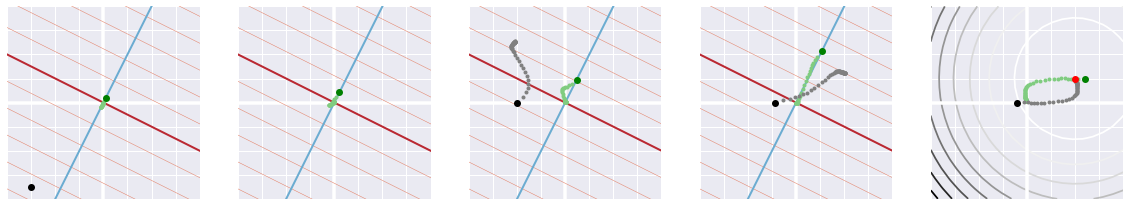

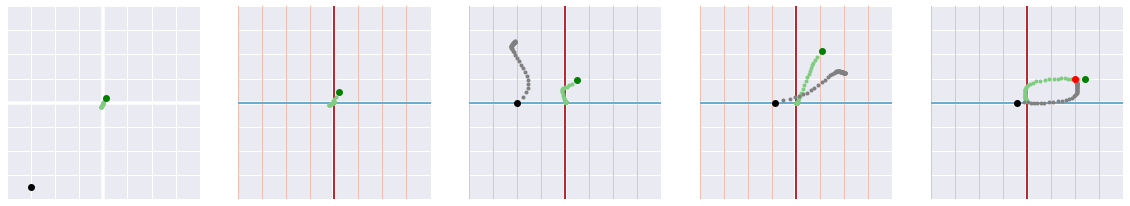

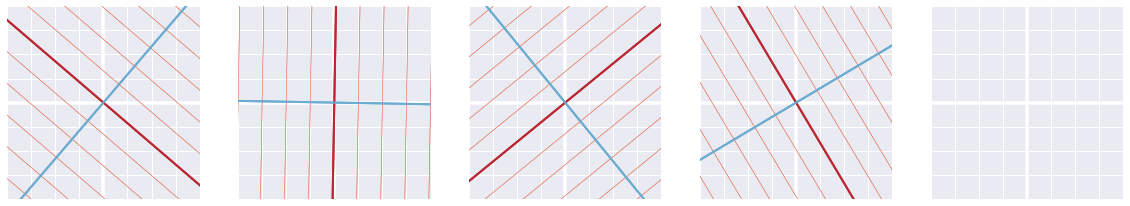

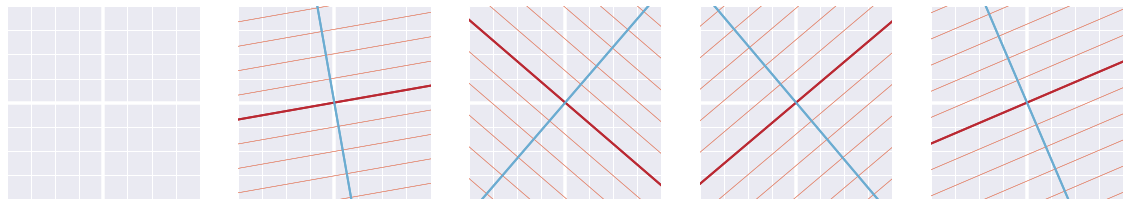

In [48]:
## ROW 1
fig, ax = plt.subplots(1, layers+1, figsize=(20,20))
for l in range(layers+1):
    square_axes(l)

for l in range(layers):
    plot_quotient(W_ss[l]['ker'], W_ss[l]['coim'], l)
    plot_vecline(W_ss[l]['ker'], l, -1)
    plot_vecline(W_ss[l]['coim'],l, 1)

for l in range(layers+1):
    for t in [c+1 for c in range(train_steps-1,-1,-1)]:
        ax[l].plot(x_t[t][l][0], x_t[t][l][1], 'o', color=[.5,.5,.5], markersize=4)
        ax[l].plot(dL_t[t][l][0], dL_t[t][l][1], 'o', color=[.5,.8,.5], markersize=4)
    ax[l].plot(x_t[0][l][0], x_t[0][l][1],'ko')
    ax[l].plot(dL_t[0][l][0], dL_t[0][l][1],'go')

# plot y
ax[-1].plot(y[0],y[1],'ro')
ax[-1].contour(hh,vv, L,10)
plt.show()

## ROW 2
fig, ax = plt.subplots(1, layers+1, figsize=(20,20))
for l in range(layers+1):
    square_axes(l)

for l in range(layers):
    plot_quotient(W_ss[l]['coker'], W_ss[l]['im'], l+1)
    plot_vecline(W_ss[l]['coker'], l+1, -1)
    plot_vecline(W_ss[l]['im'],l+1, 1)

# plot x
for l in range(layers+1):
    for t  in [c+1 for c in range(train_steps-1,-1,-1)]:
        ax[l].plot(x_t[t][l][0], x_t[t][l][1], 'o', color=[.5,.5,.5], markersize=4)
        ax[l].plot(dL_t[t][l][0], dL_t[t][l][1], 'o', color=[.5,.8,.5], markersize=4)
    ax[l].plot(x_t[0][l][0], x_t[0][l][1],'ko')
    ax[l].plot(dL_t[0][l][0], dL_t[0][l][1],'go')

# plot y
ax[-1].plot(y[0],y[1],'ro')

plt.show()

## ROW 3
fig, ax = plt.subplots(1, layers+1, figsize=(20,20))
for l in range(layers+1):
    square_axes(l)

for i in [0, train_steps-1]:
    for l in range(layers):
        plot_quotient(W_update_ss[i][l]['ker'], W_update_ss[i][l]['coim'], l)
        plot_vecline(W_update_ss[i][l]['ker'], l, -1)
        plot_vecline(W_update_ss[i][l]['coim'],l, 1)
plt.show()

## ROW 4
fig, ax = plt.subplots(1, layers+1, figsize=(20,20))
for l in range(layers+1):
    square_axes(l)

for i in [0, train_steps-1]:
    for l in range(layers):
        plot_quotient(W_update_ss[i][l]['coker'], W_update_ss[i][l]['im'], l+1)
        plot_vecline(W_update_ss[i][l]['coker'], l+1, -1)
        plot_vecline(W_update_ss[i][l]['im'],l+1, 1)
plt.show()

- W[l] moves in the direction to minimize error.
- Does this imply that x[l] also moves in the direction to minimize error?


- Specify the space of possible solutions -- global sections of x[l], but also space of W[l]?


- visualize the gradient functionals 


- Understand why for backprop:
    - dL/dW does not change over training steps (?)
    - dL/dW is specifically rank-one. What is gained by higher-rank updates. Relation to FORCE / RLS / Full-FORCE. Newton's method -> higher thank rank-one?
    

- should be able to prove why W_update is constant for deep linear networks. Implications?

In [49]:
x_array = np.array(x_t)
dL_array = np.array(dL_t)
W_array = np.array(W_t)
W_update_array = np.array(W_update)

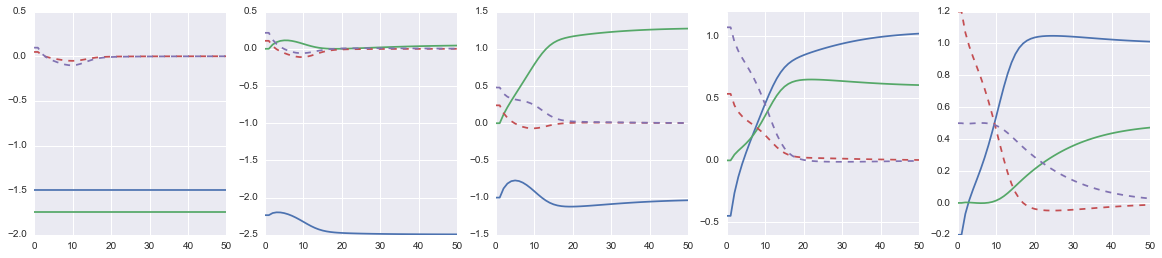

In [50]:
fig, ax = plt.subplots(1, layers+1, figsize=(20,4))
for l in range(layers+1):
    ax[l].plot(x_array[:,l,:])
    ax[l].plot(dL_array[:,l,:],'--')
plt.show()

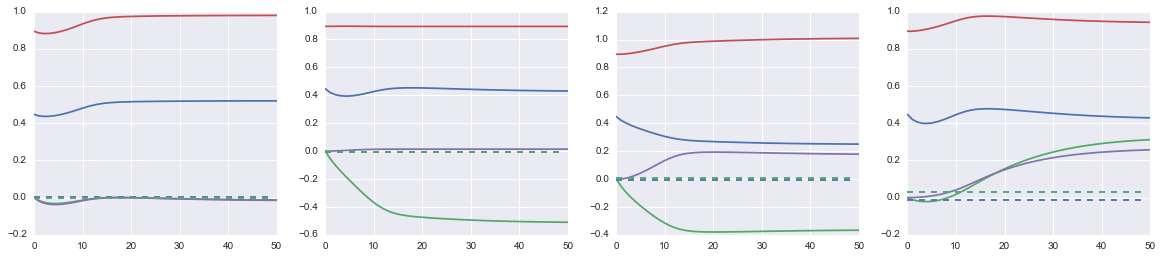

In [51]:
fig, ax = plt.subplots(1, layers, figsize=(20,4))
for l in range(layers):
    ax[l].plot(W_array[:,l,:,0])
    ax[l].plot(W_array[:,l,:,1])
    ax[l].plot(W_update_array[:,l,:,0],'--')
    ax[l].plot(W_update_array[:,l,:,0],'--')
plt.show()

In [43]:
W_update_array.shape

(10, 4, 2, 2)

In [ ]:
dL_

### Target prop in tensorflow

In [ ]:
%reset -f
%matplotlib inline

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns

In [ ]:
### Mnist data
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.examples.tutorials.mnist import mnist

mnist_data = input_data.read_data_sets("MNIST_data/", one_hot=True)
num_samples = mnist_data.train.num_examples
m_dim = mnist.IMAGE_PIXELS
p_dim = mnist.NUM_CLASSES
batch_size = 100

In [ ]:
def get_rand_batch(data):
    inds = np.random.choice(num_samples, batch_size)
    for i in range(len(data)):
        data[i] = data[i][inds]
    return inds, data

In [ ]:
x_data = mnist_data.train.images
y_data = mnist_data.train.labels

In [ ]:
### Model
tf.reset_default_graph()

layers = 5
l_dim = [m_dim] + (layers-1)*[50] + [p_dim]
stddev = 0.05
b_init = 0.1

# Placeholders
x_in = tf.placeholder(tf.float32, shape=[batch_size, m_dim], name='x_in')
y = tf.placeholder(tf.float32, shape=[batch_size, p_dim], name='y')

# hyperparameters
keep_prob = tf.placeholder(tf.float32)

# Variables
# what is best way to create arbitrary layer network?
# dicts or lists?
b = []
W = []
h = []
x = []

for i in range(layers):
    with tf.name_scope('layer'+str(i)) as scope:
        b.append(tf.Variable(tf.constant(b_init, shape=[1, l_dim[i+1]]), name='b'+str(i)))
        W.append(tf.Variable(tf.truncated_normal([l_dim[i], l_dim[i+1]], stddev=stddev), name='W'+str(i)))
        if i == 0:
            h.append(tf.add(tf.matmul(x_in, W[i]), b[i], name='h'+str(i)))
        else:
            h.append(tf.add(tf.matmul(x[i-1], W[i]), b[i], name='h'+str(i)))
        x.append(tf.nn.dropout(tf.nn.relu(h[i]), keep_prob, name='x'+str(i)))

y_hat = tf.nn.softmax(x[-1])

# Possible loss functions
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))
#loss = tf.reduce_mean(0.5*(x[-1] - y)**2, name="loss")

## Evaluation ops
# categorical output
correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_op = tf.train.AdamOptimizer(1e-3)
#train_op = tf.train.GradientDescentOptimizer(0.1)
train = train_op.minimize(loss)

In [ ]:
tf.scalar_summary('loss', loss)
tf.scalar_summary('learning rate', train_op._lr_t)
tf.scalar_summary('learning rate2', train_op._lr)
tf.scalar_summary('accuracy', accuracy)

merged_summary_op = tf.merge_all_summaries()

In [ ]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs', sess.graph)

for i in range(10000):
    inds_batch, [x_batch, y_batch] = get_rand_batch([x_data, y_data])
    _, loss_val, summary_str, accuracy_val = sess.run([train, loss, merged_summary_op, accuracy],
                                                      feed_dict={x_in: x_batch, y: y_batch, keep_prob: 0.95})
    summary_writer.add_summary(summary_str, i)
    
    if i % 100 == 0:
        print "iter:", "%04d" % (i), \
              "loss:", "{:.4f}".format(loss_val), \
              "accuracy:", "{:.2f}".format(accuracy_val)

print "finished"

In [ ]:
plt.plot(sess.run(x[-4][0,:], feed_dict={x_in: x_batch, y: y_batch, keep_prob: 1}))

plt.show()